In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

# to glob files
import glob
# to import / resize images
import cv2 # Open CV 3.1, on Mac OS brew install opencv

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# to print classification stats in a nice format
from sklearn.metrics import classification_report

# for dynamic graph rendering
from IPython import display

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 13]

cmaps = ['Spectral', 'coolwarm', 'bwr', 'seismic']
cmap = 'bwr'

In [2]:
# DATA FROM: http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
image_dir = '101_ObjectCategories'

In [3]:
class_names = ['airplanes', 'Faces', 'Leopards', 'Motorbikes']
# class_names = ['airplanes', 'Faces', 'Leopards', 'Motorbikes', 'bonsai', 'bass', 'beaver', 'binocular', 'butterfly']

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [5]:
class Swish(nn.Module):
    def forward(self, x):
        return x * nn.Sigmoid(x)

In [6]:
width = 320
height = 200
depth = 3

# model
model = nn.Sequential(
    # input 3x96x96, output 16 channels, 45x45
    nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=0),
    # input 16x45x45 output 32x45x45
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    # input 32x45x45 output 32x23x23
    nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Dropout2d(p=0.25),

    # input 32x23x23 output 32x23x23
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    # input 32x23x23 output 64x12x12
    nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    
    nn.Dropout2d(p=0.25),

    # input 64x12x12 output 128x12x12
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    # input 128x12x12 output 128x6x6
    nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    
    nn.Dropout2d(p=0.25),

    Flatten(),
    nn.Linear(4608, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.5),
    nn.Linear(512, len(class_names)),
    nn.Softmax(dim=1),
)
    

In [7]:
data = []
labels = []

In [8]:
files = glob.glob(image_dir+'/*/*.jpg')

In [9]:
for file in files:
    label = file.split("/")[-2]
    if label not in class_names:
        continue
    img = cv2.imread(file)
    img_t = cv2.resize(img, (96, 96))
    data.append(img_t)
    labels.append(label)

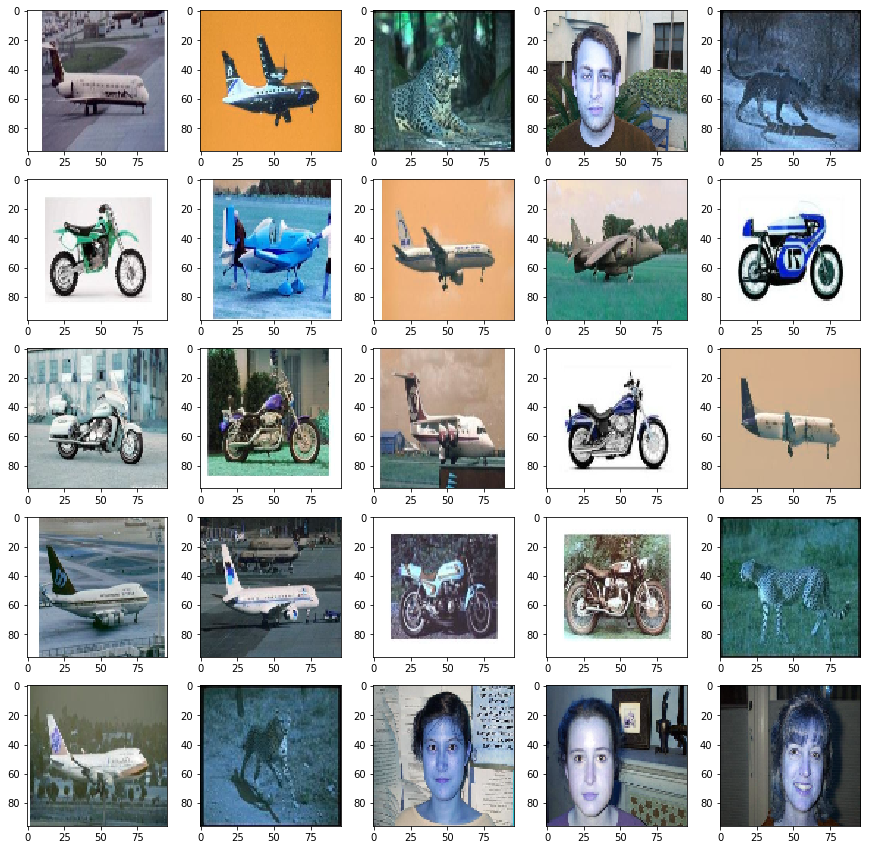

In [10]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(data[np.random.randint(0, len(data))])

### Note: colors are off because we're using a different color space, but it doesn't really matter here.

In [11]:
# LabelBinarizer is used to 
lb = LabelBinarizer()
labelsb = lb.fit_transform(labels)
lb.classes_

array(['Faces', 'Leopards', 'Motorbikes', 'airplanes'], dtype='<U10')

In [12]:
print(len(labels))
print(labelsb[0])
print(labels[0])

2233
[0 0 0 1]
airplanes


In [13]:
# scale all our data (images encoded in RGB 24 bits -> [0-255] per pixel) to [0, 1]
data = np.array(data, dtype=float) / 255.0

In [14]:
data.shape

(2233, 96, 96, 3)

In [15]:
# reshape to what PyTorch expects, i.e. batch first, then channels (colors), width, height
data = data.swapaxes(1,3) 

In [16]:
data.shape
# 2233 images, colors (R,G,B), 96x96 pixels each

(2233, 3, 96, 96)

In [17]:
# split training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labelsb, test_size=0.25, stratify=labelsb, random_state=42)

In [18]:
# convert to torch Tensors to feed to the network
trainX = torch.Tensor(trainX)
trainY = torch.Tensor(trainY)
testX = torch.Tensor(testX)
testY = torch.Tensor(testY)

In [19]:
# define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [20]:
def train():
    optimizer.zero_grad()
    output = model(trainX)
    loss = loss_fn(output, trainY)
    loss.backward()
    optimizer.step()
    return loss.item()

In [21]:
losses = []
step = 0

KeyboardInterrupt: 

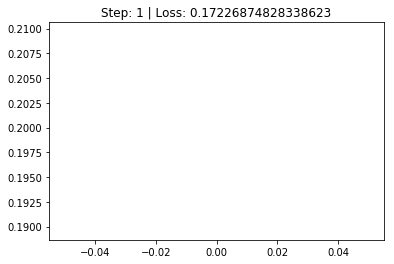

In [22]:

fig = plt.figure(1)
ax = fig.add_subplot(111)
fig.show()

while step < 50:
    loss = train()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    ax.plot(losses, 'b-')
    ax.set_title("Step: {} | Loss: {}".format(step, loss))
    losses.append(loss)
    step += 1

In [345]:
from datetime import datetime
torch.save(model.state_dict(), 'Stridenet-{}.pth'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

In [23]:
# reload a model:
# Stridenet-20190124_152007.pth
model.load_state_dict(torch.load('Stridenet-20190124_152007.pth'))
model.eval()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
  (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout2d(p=0.25)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (12): ReLU()
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Dropout2d(p=0.25)
  (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [24]:
predictions = model(testX)

In [26]:
# Classification_report prints a nice output of the performances of our model

# detach().numpy() is necessary to detach the Tensor data and conver to numpy array
# argmax gives us the highest probability for each 
print(classification_report(testY.detach().numpy().argmax(axis=1),  
                            predictions.detach().numpy().argmax(axis=1),
                            target_names=lb.classes_))

              precision    recall  f1-score   support

       Faces       0.98      1.00      0.99       109
    Leopards       1.00      0.88      0.94        50
  Motorbikes       1.00      0.92      0.96       200
   airplanes       0.90      0.99      0.95       200

   micro avg       0.96      0.96      0.96       559
   macro avg       0.97      0.95      0.96       559
weighted avg       0.96      0.96      0.96       559



In [27]:
imageIdx = 2 # 1,3 = Motobike, 8 = Face, 2 = airplane

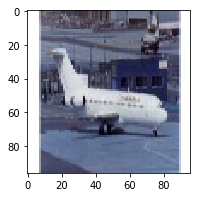

In [28]:
fig = plt.figure(figsize=(3,3))
plt.imshow(testX[imageIdx].detach().numpy().swapaxes(0,2))

In [29]:
testY[imageIdx]

tensor([0., 0., 0., 1.])

In [30]:
lb.classes_

array(['Faces', 'Leopards', 'Motorbikes', 'airplanes'], dtype='<U10')

In [32]:
predictions[imageIdx]

tensor([3.8800e-04, 2.5830e-04, 1.6966e-05, 9.9934e-01],
       grad_fn=<SelectBackward>)

#### -> Prediction is 0.999 = 99.9% for airplane

## Visualizing 'hidden' layers

#### Note, we're not visualizing the 'kernels' (values that were trained) per se, but the images that are generated through convolution by those kernels, i.e. the transformation an input image goes through when computed by the network.

In [34]:
# create a wrapper model, which can extract layers as needed
class SpyNet(nn.Module):
    def __init__(self, trained_model, depth):
        super(SpyNet, self).__init__()
        self.features = nn.Sequential(*list(trained_model.eval())[:depth])
    def forward(self, x):
        x = self.features(x)
        return x

### Let's look at 2 images and how the model transforms them

In [36]:
imageIdx1 = 3 # Motorbike
imageIdx2 = 9 # Face

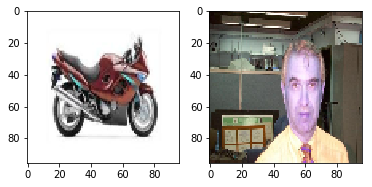

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax[0].imshow(testX[imageIdx1].detach().numpy().swapaxes(0,2))
ax[1].imshow(testX[imageIdx2].detach().numpy().swapaxes(0,2))

In [79]:
spy_model = SpyNet(model, 28)

In [80]:
output = spy_model(testX)
output.size()

torch.Size([559, 4])

In [81]:
# output

In [82]:
npo = output.detach().numpy()
npo.shape

(559, 4)

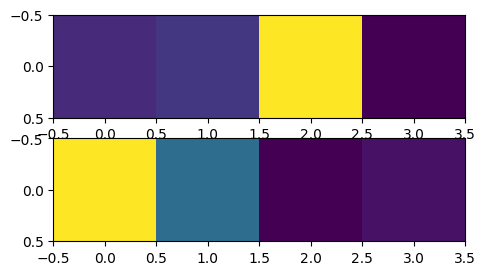

In [83]:
# Some fancy rendering of the hidden layers
# Output images from each kernel is displayed so that the 2 input images are shows on successive rows.
# 1st row is 1st image, 2nd row is second image for the same kernels etc...

import math
m = npo.shape[1] # nb of kernels
if len(npo.shape) > 2:
    w = npo.shape[2] # size of image
    c = min(m, int(math.ceil(np.sqrt(m)))) #250 / max(w, 24))) # nb columns
    r = int(math.ceil(m / c)) # nb rows
    index = np.array(range(0, r * c)).reshape(r, -1)
    # figure some math to layout the images
    fig, ax = plt.subplots(nrows=2*r, ncols=c, figsize=(15, 2 * (15 / c) * r))
    for id in range(m):
        ix = np.where(index==id)
        ax[2*ix[0][0]  , ix[1][0]].imshow(npo[imageIdx1][id].swapaxes(0,1), cmap=cmap)
        ax[2*ix[0][0]+1, ix[1][0]].imshow(npo[imageIdx2][id].swapaxes(0,1), cmap=cmap)
else:
    # reshape the output to look like some sort of image to visualize
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), dpi=100)
    ax[0].imshow(npo[imageIdx1].reshape(-1, min(m, 64)))
    ax[1].imshow(npo[imageIdx2].reshape(-1, min(m, 64)))